In [ ]:
%pip install numpy
%pip install pandas 
%pip install mne 
%pip install scikit-learn
%pip install mne-features
%pip install matplotlib

In [3]:
import numpy as np
import pandas as pd

In [4]:
import mne

### Load EEG dataset/info into MNE ###
raw = mne.io.read_raw_eeglab("data/imagined_emotion.set")
print(raw.info)

Reading c:\Users\matth\Downloads\Neurotech\NeurotechAcademy\example_notebooks\data\imagined_emotion.fdt


C:\Users\matth\AppData\Local\Temp\ipykernel_38024\1825451887.py:4: RuntimeWarning: Data file name in EEG.data (sub-01_task-ImaginedEmotion_eeg.fdt) is incorrect, the file name must have changed on disk, using the correct file name (imagined_emotion.fdt).
  raw = mne.io.read_raw_eeglab("data/imagined_emotion.set")


<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A10, A11, A12, A13, A14, A15, ...
 chs: 224 EEG
 custom_ref_applied: False
 dig: 227 items (3 Cardinal, 224 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 224
 projs: []
 sfreq: 256.0 Hz
>


In [5]:
### Call Raw.get_data() to return the entire 75 minute EEG recording as a 2D numPy array ###
data = raw.get_data()

print(f"Raw data shape: {data.shape}")
print(f"Number of channels: {data.shape[0]}")
print(f"Number of timesteps at a sampling frequency of 256 timesteps per second: {data.shape[1]}")

Raw data shape: (224, 1154304)
Number of channels: 224
Number of timesteps at a sampling frequency of 256 timesteps per second: 1154304


In [6]:
EMOTIONS = {
    "awe", "frustration", "joy", "anger", "happy", "sad", "love", "fear",
    "compassion", "jealousy", "content", "grief", "relief", "excite", "disgust"
}

def epoch_from_tsv(raw, tsv_path, epoch_len=2.0):

    df = pd.read_csv(tsv_path, sep="\t")
    df = df[["onset", "value"]]

    sfreq = raw.info["sfreq"]
    data = raw.get_data()
    n_ch, n_times = data.shape
    samples_per_epoch = int(round(epoch_len * sfreq))
    trials_by_emotion = {}
    for i, row in df.iterrows():
        if row["value"] in EMOTIONS:
            emotion = row["value"]
            press1_idx = df.index[(df.index > i) & (df["value"] == "press1")]
            if len(press1_idx) == 0:
                continue
            press1_onset = df.loc[press1_idx[0], "onset"]
            exit_idx = df.index[(df.index > press1_idx[0]) & (df["value"] == "exit")]
            if len(exit_idx) == 0:
                continue
            exit_onset = df.loc[exit_idx[0], "onset"]
            start = int(round(press1_onset * sfreq))
            stop = int(round(exit_onset * sfreq))
            if stop > n_times:
                stop = n_times
            trial = data[:, start:stop]
            if trial.shape[1] >= samples_per_epoch:
                trials_by_emotion.setdefault(emotion, []).append(trial)
    min_len = min(min(t.shape[1] for t in trials) for trials in trials_by_emotion.values())
    min_len = (min_len // samples_per_epoch) * samples_per_epoch
    X_list, y_list = [], []
    for emotion, trials in trials_by_emotion.items():
        for trial in trials:
            trial = trial[:, :min_len]
            n_epochs = min_len // samples_per_epoch
            for j in range(n_epochs):
                seg = trial[:, j*samples_per_epoch:(j+1)*samples_per_epoch]
                X_list.append(seg)
                y_list.append(emotion)

    X = np.stack(X_list, axis=0)
    y = np.array(y_list)
    return X, y

In [7]:
### Split/epoch the continuous EEG recording into 2 second long samples each with an associated emotion label according to the event offsets defined in events.tsv ###

X, y = epoch_from_tsv(raw, "data/events.tsv")

### Shape is now (number of samples x number of channels x number of timesteps per epoch) ###
print(f"EEG data shape: {X.shape}")
print(f"Class labels shape: {y.shape}")

EEG data shape: (405, 224, 512)
Class labels shape: (405,)


In [8]:
unique_labels, counts = np.unique(y,return_counts=True)
print("Dataset label counts:")
print(np.asarray((unique_labels, counts)).T)

Dataset label counts:
[['anger' '27']
 ['awe' '27']
 ['compassion' '27']
 ['content' '27']
 ['disgust' '27']
 ['excite' '27']
 ['fear' '27']
 ['frustration' '27']
 ['grief' '27']
 ['happy' '27']
 ['jealousy' '27']
 ['joy' '27']
 ['love' '27']
 ['relief' '27']
 ['sad' '27']]


In [9]:
from sklearn.model_selection import train_test_split

### Randomly split the dataset into an 80% training split and 20% testing split while maintaining the balanced class distribution ###
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training dataset shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing dataset shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training dataset shape: (324, 224, 512)
Training labels shape: (324,)
Testing dataset shape: (81, 224, 512)
Testing labels shape: (81,)


In [10]:
unique_labels, counts = np.unique(y_train,return_counts=True)
print("Training set label counts:")
print(np.asarray((unique_labels, counts)).T)
print()
print("Test set label counts:")
unique_labels, counts = np.unique(y_test,return_counts=True)
print(np.asarray((unique_labels, counts)).T)

Training set label counts:
[['anger' '22']
 ['awe' '22']
 ['compassion' '22']
 ['content' '21']
 ['disgust' '21']
 ['excite' '22']
 ['fear' '21']
 ['frustration' '21']
 ['grief' '22']
 ['happy' '22']
 ['jealousy' '21']
 ['joy' '22']
 ['love' '21']
 ['relief' '22']
 ['sad' '22']]

Test set label counts:
[['anger' '5']
 ['awe' '5']
 ['compassion' '5']
 ['content' '6']
 ['disgust' '6']
 ['excite' '5']
 ['fear' '6']
 ['frustration' '6']
 ['grief' '5']
 ['happy' '5']
 ['jealousy' '6']
 ['joy' '5']
 ['love' '6']
 ['relief' '5']
 ['sad' '5']]


In [11]:
from mne_features.feature_extraction import FeatureExtractor

### Extract frequency bandpower and spectral entropy features over the time domain for each channel ###
fe = FeatureExtractor(sfreq=raw.info['sfreq'], selected_funcs=['pow_freq_bands', 'spect_entropy'])

### After transformation, the data shape is (number of samples x number of features) ###
X_train_feats = fe.fit_transform(X_train)
print(f"Shape of training set features: {X_train_feats.shape}")
X_test_feats = fe.fit_transform(X_test)
print(f"Shape of training set features: {X_test_feats.shape}")


Shape of training set features: (324, 1344)
Shape of training set features: (81, 1344)


In [12]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### Fit a linear Support Vector Machine classifier to the training data and labels ###
model = SVC(kernel="linear")
model.fit(X_train_feats, y_train)

### Use the fitted model to predict the labels of the test data ###
predictions = model.predict(X_test_feats)

### Compute accuracy between the predicted class labels and real class labels on the test set ###
accuracy = accuracy_score(y_test, predictions)
print(f"15 Class Accuracy: {accuracy*100:.1f}%")


15 Class Accuracy: 63.0%


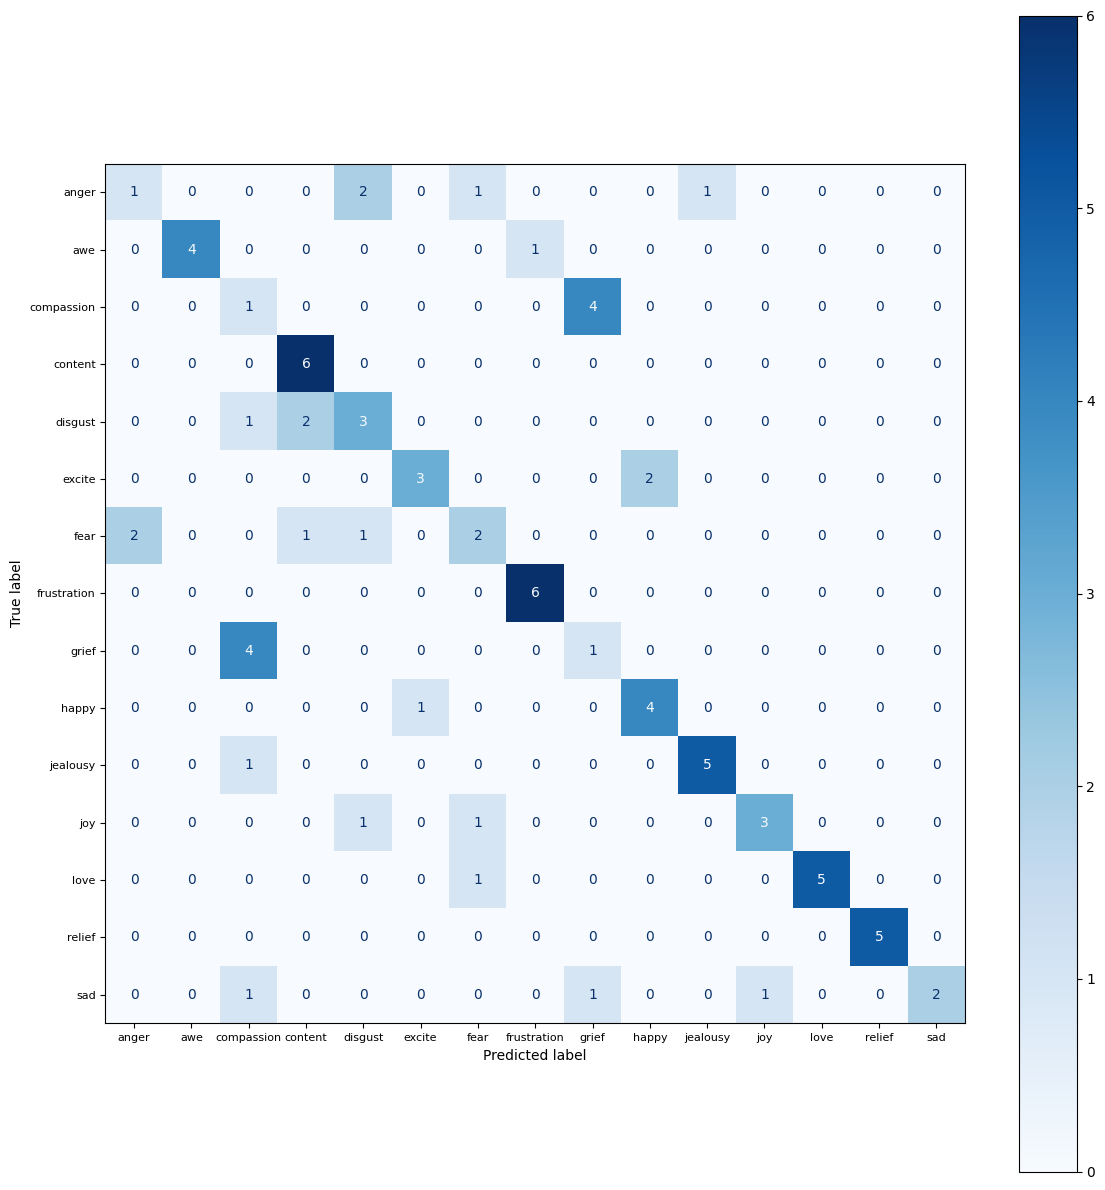

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = np.unique(y_test)
cm = confusion_matrix(y_test, predictions, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap="Blues", colorbar=True)

plt.xticks(rotation=0, ha="center", fontsize=8)
plt.yticks(rotation=0, ha="right", fontsize=8)

plt.tight_layout()
plt.show()